In [2]:
!pip install -r code/requirements.txt

In [3]:
!apt-get install -y libgl1-mesa-glx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
import os
import shutil
from glob import glob

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

# Data Analysis (EDA)

In [4]:
train_dir = 'input/data/train'
eval_dir = 'input/data/eval'

df_train = pd.read_csv(os.path.join(train_dir, 'train.csv')) 
df_eval = pd.read_csv(os.path.join(eval_dir, 'info.csv'))

In [5]:
df_train.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [212]:
# print statistics of image data
`

img_info = {'heights':[], 'widths':[], 'means':[], 'stds':[]}
for person_path in tqdm(person_dirs):
    img_list = glob(f'{person_path}/*')
    for img_path in img_list:
        image = Image.open(img_path)
        img_info['heights'].append(np.array(image).shape[0])
        img_info['widths'].append(np.array(image).shape[1])
        img_info['means'].append(np.array(image).mean(axis=(0,1)))
        img_info['stds'].append(np.array(image).std(axis=(0,1)))

  0%|          | 0/2700 [00:00<?, ?it/s]

In [217]:
print(f'Total number of people : {len(person_dirs)}')
print(f'Total number of images : {len(img_info["heights"])}')
print(f'Minimum height of image data : {np.min(img_info["heights"])}')
print(f'Maximum height of image data : {np.max(img_info["heights"])}')
print(f'Minimum width of image data : {np.min(img_info["widths"])}')
print(f'Maximum width of image data : {np.min(img_info["widths"])}')
print(f'RGB mean of image data : {np.mean(img_info["means"], axis=0)/255}')
print(f'RGB std of image data : {np.mean(img_info["stds"], axis=0)/255}')

Total number of people : 2700
Total number of images : 18900
Minimum height of image data : 512
Maximum height of image data : 512
Minimum width of image data : 384
Maximum width of image data : 384
RGB mean of image data : [0.56019358 0.52410121 0.501457  ]
RGB std of image data : [0.23318603 0.24300033 0.24567522]


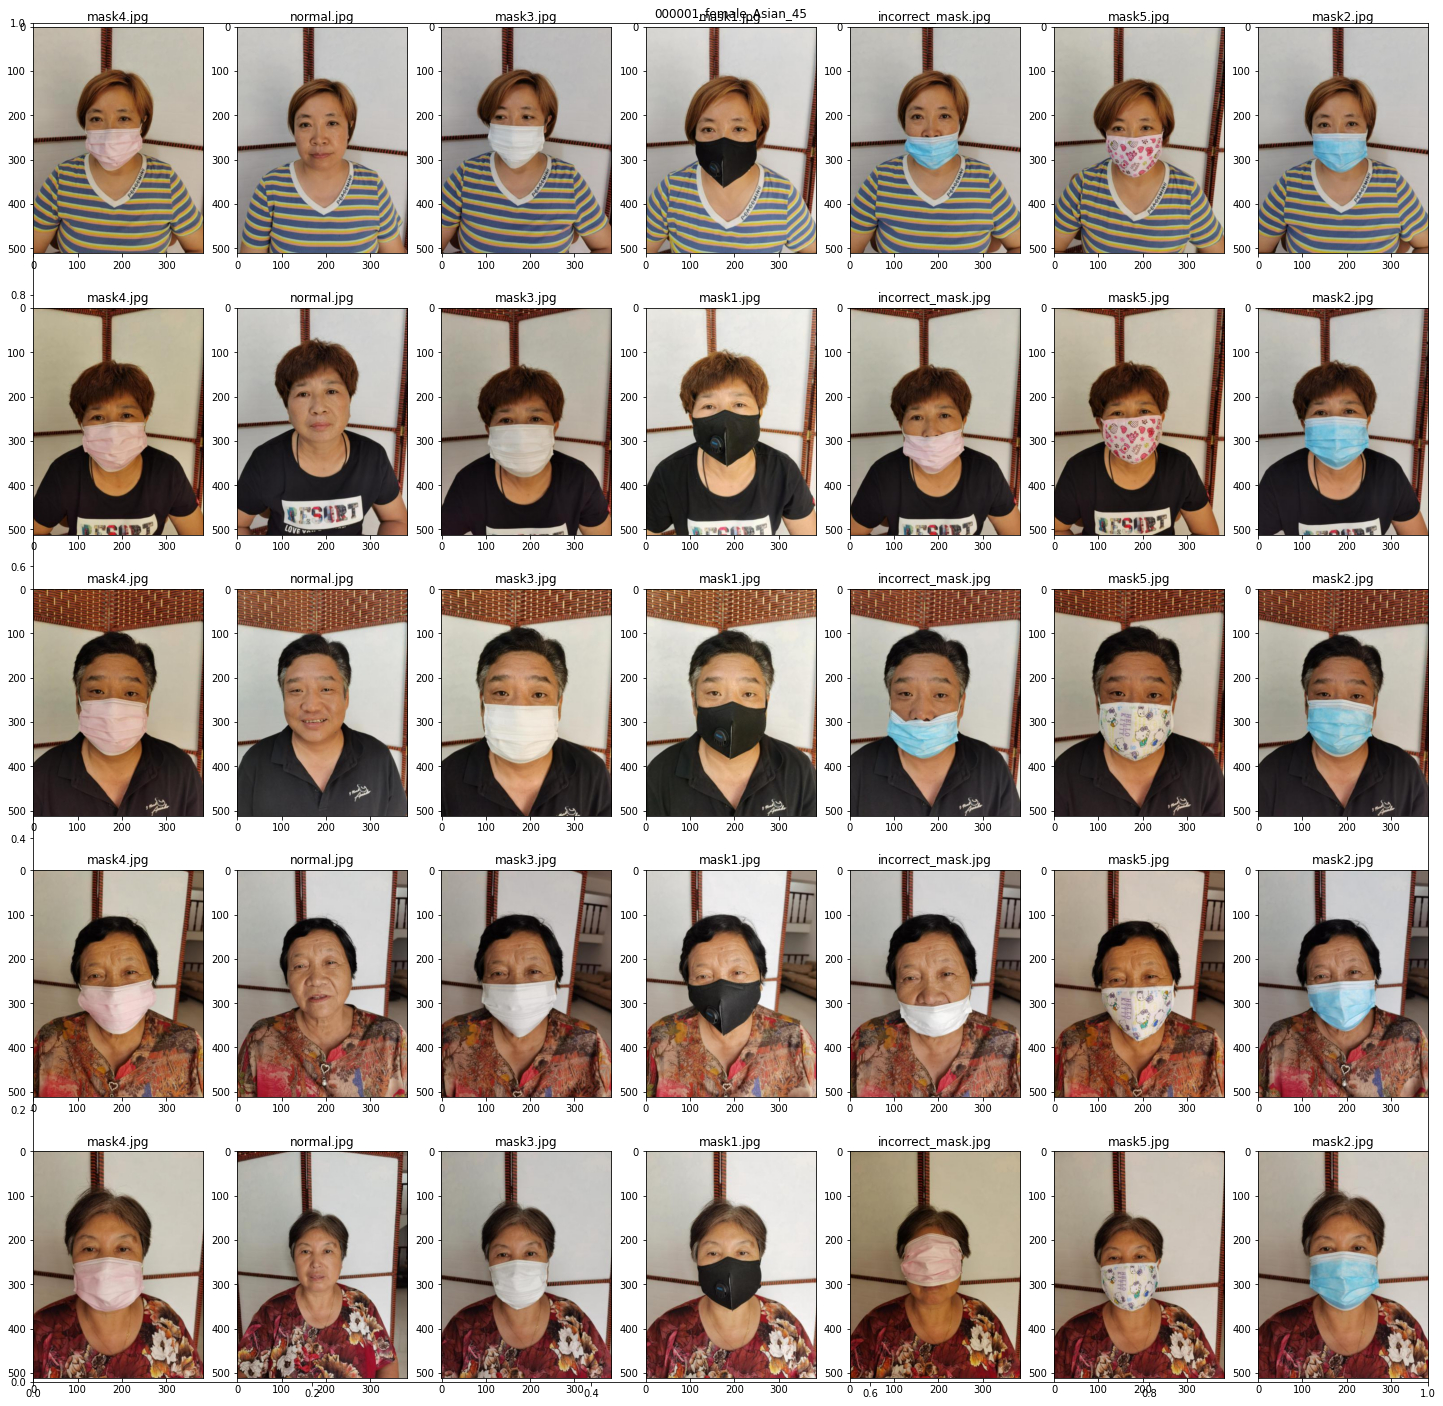

In [6]:
# show images (img_idx~img_idx+4)
img_idx = 0

fig = plt.figure(figsize = (25, 25))
plt.title(df_train.path[img_idx])
for row in range(img_idx, img_idx+5):
    sample_dir = f'{train_dir}/images/{df_train.path[row]}'
    img_list = [img.split('/')[-1] for img in glob(f'{sample_dir}/*')]
    for idx, val in enumerate(img_list):
        ax = fig.add_subplot(5, 7, row*7+idx+1)
        path = os.path.join(sample_dir, val)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        ax.set_title(val)

In [7]:
# count each image type
np_train = np.array(df_train)
img_type_dic = {}
for info in np_train:
    img_list = [img.split('/')[-1] for img in glob(f'{train_dir}/images/{info[4]}/*')]
    img_type_list = [img_type.split('.')[-1] for img_type in img_list]
    for img_type in img_type_list:
        if img_type not in img_type_dic:
            img_type_dic[img_type] = 1
        else:
            img_type_dic[img_type] += 1

print(f'types of images : {img_type_dic}')

types of images : {'jpg': 18035, 'png': 511, 'jpeg': 354}


In [8]:
# create dictionary that has key : class, value : data path
class_dic = {i : [] for i in range(18)}
for info in np_train:
    if info[1] == 'male':
        if info[3] < 30:
            class_num = 0
        elif info[3] >= 30 and info[3] < 60:
            class_num = 1
        else:
            class_num = 2
    elif info[1] == 'female':
        if info[3] < 30:
            class_num = 3
        elif info[3] >= 30 and info[3] < 60:
            class_num = 4
        else:
            class_num = 5
    
    img_list = sorted([img.split('/')[-1] for img in glob(f'{train_dir}/images/{info[4]}/*')])
    copy_class_dir = [1, 0, 0, 0, 0, 0, 2]
    for i in range(len(img_list)):
        target_dir = os.path.join(train_dir, 'images', info[4], img_list[i])
        class_dic[copy_class_dir[i]*6+class_num].append(target_dir)

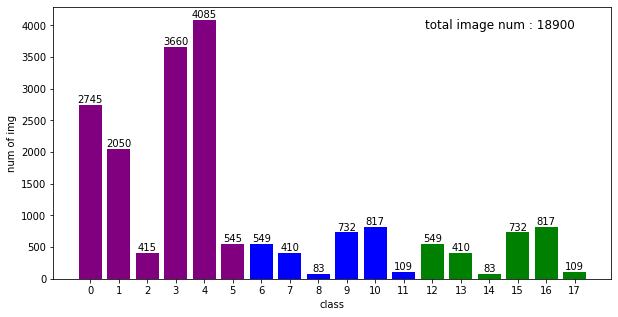

In [9]:
# create dictionary that has key : class, value : number of images
class_dic_cnt = {i : 0 for i in range(18)}
for i in range(18):
    class_dic_cnt[i] = len(class_dic[i])

x = list(class_dic_cnt.keys())
y = list(class_dic_cnt.values())
fig, ax = plt.subplots(figsize=(10,5))
bar = ax.bar(x, y, color=['purple']*6+['blue']*6+['green']*6)
for i in range(18):
    ax.text(x[i], y[i], y[i], ha='center', va='bottom')
ax.set_xticks(x)
ax.set_xlabel('class')
ax.set_ylabel('num of img')
ax.text(17, 4000, f"total image num : {sum(class_dic_cnt.values())}", size = 12, ha='right', va='center')
plt.show()